In [1]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from astropy.io import fits

from networks import ForkCNN
from train import train_nn, prepare_dataloader, ddp_setup, load_model, predict
from dataset import FiberDataset
import config

fits_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples.csv'
fig_dir = '/xdisk/timeifler/wxs0703/kl_nn/figures/'
model_dir = '/xdisk/timeifler/wxs0703/kl_nn/model/'

In [1]:
from kl_tools import priors

In [2]:
world_size = torch.cuda.device_count()
save_every = 1
nepochs = config.train['epoch_number']
batch_size = config.train['batch_size']
nfeatures = config.train['feature_number']
f_valid = config.train['validation_split']

In [3]:
mp.spawn(train_nn, args=(world_size, save_every, nepochs, batch_size, nfeatures, f_valid), nprocs=world_size)

/home/u2/wxs0703/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/u2/wxs0703/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
INFO:Trainer:[TRAIN] Epoch: 1 Loss: 0.5588725665009222 Time: 1:6
INFO:Trainer:[VALID] Epoch: 1 Loss: 0.5321110703336721 Time: 0:7
INFO:Trainer:[TRAIN] Epoch: 2 

In [3]:
losses = pd.read_csv(join(model_dir, 'losses.csv'))

In [6]:
train_losses = losses.iloc[0, 1:]
valid_losses = losses.iloc[1, 1:]

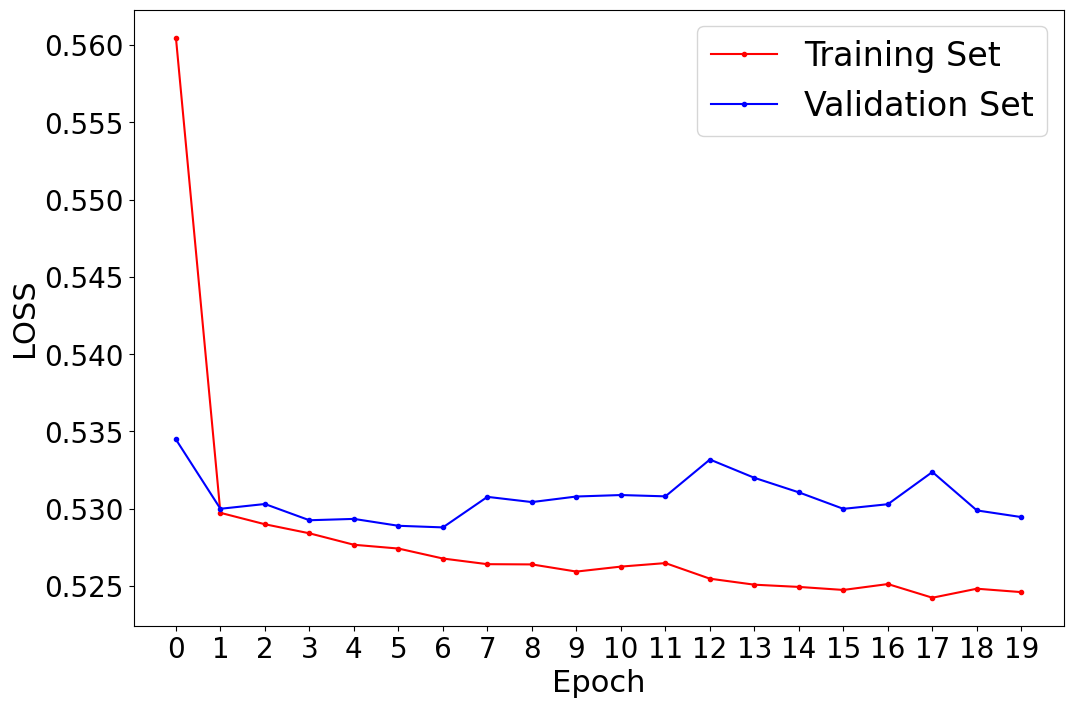

In [7]:
plt.figure(figsize=(12,8))

plt.plot(train_losses, 'r.-', label="Training Set")
plt.plot(valid_losses, 'b.-', label='Validation Set')

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("LOSS", fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.legend(fontsize=24)
plt.show()

In [3]:
ddp_setup(0, 1)

In [4]:
model_file = join(model_dir, 'test_model19')
model = load_model(path=model_file,strict=True, assign=True)

In [5]:
# Get data loader
data_args = list(config.data.values())
test_ds = FiberDataset(f_valid, True, *data_args)
test_dl = DataLoader(test_ds,
                     batch_size=batch_size,
                     pin_memory=True,
                     shuffle=False,
                     sampler=DistributedSampler(test_ds))

In [6]:
pred, true, loss = predict(nfeatures, test_dl, model)
print('Test LOSS:',loss)
diff = pred - true

Test LOSS: 0.0805469237267971


<Figure size 800x600 with 0 Axes>

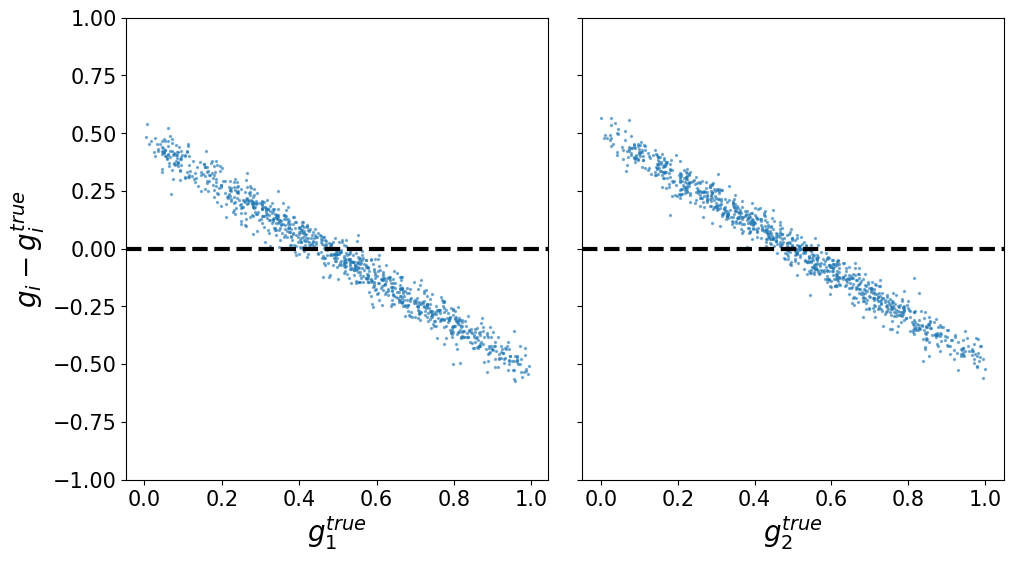

In [7]:
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

axes[0].scatter(true[:,1], diff[:,1], s=2, alpha=0.5)
im = axes[1].scatter(true[:,2], diff[:,2], s=2, alpha=0.5)
axes[0].set_ylim(-1,1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

axes[0].scatter(true[:,1], diff[:,1], s=2, alpha=0.5)
im = axes[1].scatter(true[:,2], diff[:,2], s=2, alpha=0.5)
axes[0].set_ylim(-1,1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.show()